In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_color_codes('deep')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition

plt.rcParams['figure.figsize'] = (8, 6)

meanprops = {'marker':'o',
             'markerfacecolor':'white', 
             'markeredgecolor':'black',
             'markeredgewidth': 1.5,
             'markersize':'10'}

# Functions

In [2]:
# Scree plot
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xticks(np.arange(0, pca.n_components_)+1)
    plt.xlabel("rank of the inertia axis")
    plt.ylabel("percentage of inertia")
    plt.title("Scree plot")
    
# Correlation circles
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # Display factorial planes in axis_ranks
        if d2 < n_comp:
            # Initialize the figure
            fig, ax = plt.subplots(figsize=(7,6))

            # Determine graph limits
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Display arrows
            # If there are more than 30 arrows, do not display the triangle at their end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see doc: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', 
                                 rotation=label_rotation, color="blue", alpha=0.5)

            # Display the circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define graph limits
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # Display horizontal and vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Axis names with explained inertia percentage
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation circle (F{} and F{})".format(d1+1, d2+1))


# Projection on the principal components
def display_pca(X, pcs, axis_ranks, clusters=None, labels=None, show_features=True, xmin=None, xmax=None, ymin=None, ymax=None):
    for d1, d2 in axis_ranks:
        fig, ax = plt.subplots()
        for cluster in np.unique(clusters):
            mask = clusters == cluster
            ax.scatter(X[mask, d1], X[mask, d2], label='Cluster {}'.format(cluster))
        
        xmin = ax.get_xlim()[0] if xmin is None else xmin
        xmax = ax.get_xlim()[1] if xmax is None else xmax
        ymin = ax.get_ylim()[0] if ymin is None else ymin
        ymax = ax.get_ylim()[1] if ymax is None else ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        if show_features:
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
            pcs[d1,:]*xmax, pcs[d2,:]*ymax, 
            angles='xy', scale_units='xy', scale=1, color="grey")
            # Display feature names  
            if labels is not None:  
                for l,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x*xmax, y*ymax, labels[l], fontsize='14', ha='left', va='center', 
                                color="blue", alpha=0.5)
        
        plt.title('Projection of {} individuals'.format(X.shape[0]))
        plt.xlabel('F{}'.format(d1+1))
        plt.ylabel('F{}'.format(d2+1))
        plt.legend();

# RFM Segmentation

In [3]:
df_rfm = pd.read_csv('./data/df_rfm.csv', index_col=0)
df_rfm.head()

,recency,frequency,mean_spending
customer_unique_id,,,
4b3207464f5f7a48a7f63fa0b1251d86,601,1,9.9
527cd2850ef91088969ffbef0103dec3,601,1,11.9
29a63a400c3ca9982907ce8de1f19527,601,1,10.9
b6b2c3c8fd76769b478618a3c2505009,601,1,10.9
f7be9bec658c62ab6240b44cd26c0b84,601,2,10.4


In [4]:
df_rfm.dtypes

recency            int64
frequency          int64
mean_spending    float64
dtype: object

## KMeans

In [5]:
from sklearn.cluster import KMeans

In [6]:
# Prepare data for clustering
X_rfm = df_rfm.copy()

# Centering and scaling
scaler = StandardScaler()
X_rfm_scaled = scaler.fit_transform(X_rfm)
# Convert back to DataFrame
X_rfm_scaled = pd.DataFrame(X_rfm_scaled, columns=X_rfm.columns, index=X_rfm.index)

### Analysis with Yellowbrick

In [7]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 6)

We will use the `KElbowVisualizer` function from the `yellowbrick` package to apply the elbow method to our data and determine the optimal number of clusters.

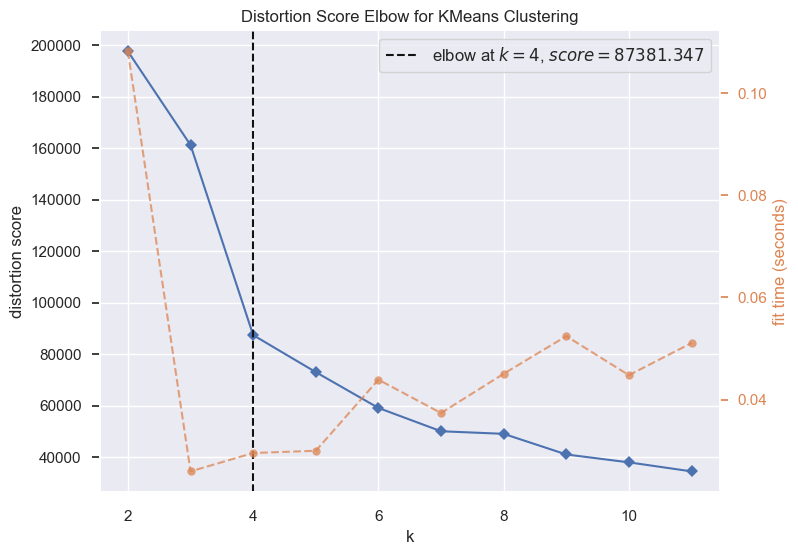

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

In [9]:
plt.rcParams['figure.figsize'] = (8, 6)

By default, the metric used is `distortion`, which calculates the sum of squared distances between each point and its cluster. Other metrics, such as `calinski_harabasz`, can also be used.

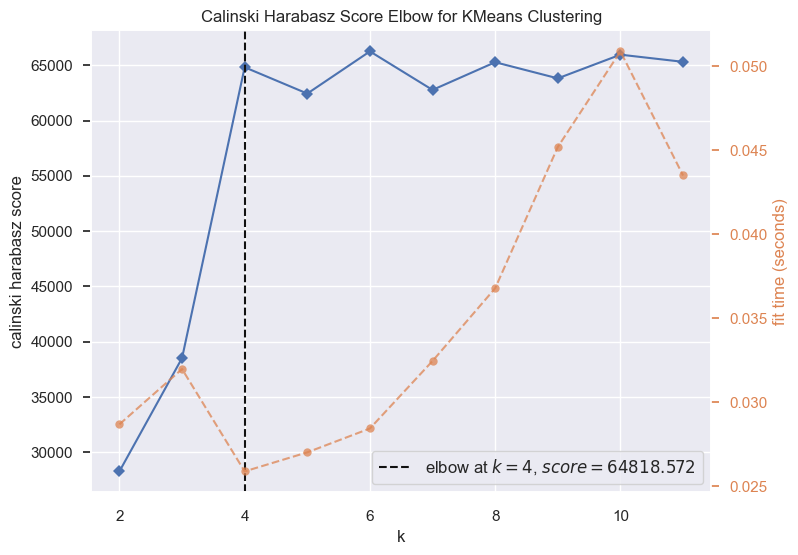

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [10]:
# Instantiate the clustering model and visualizer 
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz')

visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

To determine if a point x belongs to the correct cluster, we can measure its silhouette coefficient. It ranges from -1 to 1, and the closer it is to 1, the better the assignment of x to its cluster. To evaluate clustering, we can calculate its average silhouette coefficient.

In [11]:
# Take a sample of the data for faster computation
X_rfm_sample = X_rfm.sample(10000, random_state=1)
X_rfm_scaled_sample = scaler.transform(X_rfm_sample)
# Convert back to DataFrame
X_rfm_scaled_sample = pd.DataFrame(X_rfm_scaled_sample, index=X_rfm_sample.index, 
                                   columns=X_rfm_sample.columns)

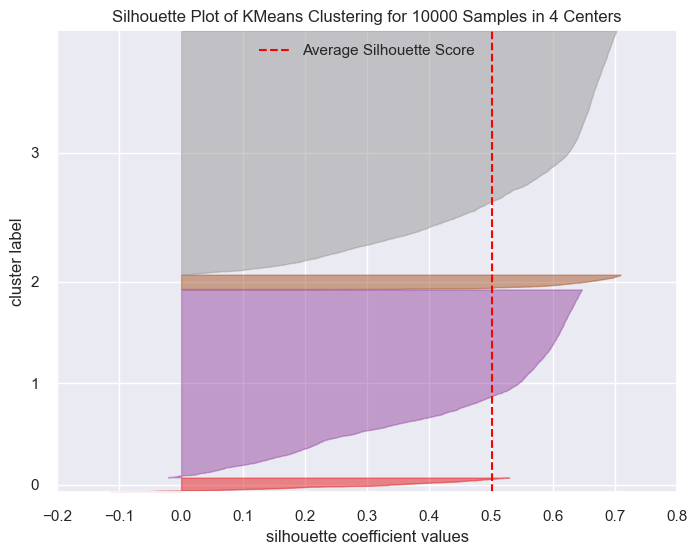

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [12]:
n_clust = 4
# Instantiate the clustering model and visualizer
kmeans = KMeans(n_clust, random_state=5)
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_rfm_scaled_sample)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

Clusters 0 and 1 are much larger than the others, meaning they contain more points. We can also see that the silhouette coefficient is negative for some points, indicating they were assigned to the wrong cluster. The dashed line indicates the average silhouette coefficient.

We can directly calculate the average silhouette coefficient using `sklearn.metrics.silhouette_score`.

In [13]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
silhouette_score(X_rfm_scaled_sample, labels, metric='euclidean')

np.float64(0.5010023255571486)

### Clustering

In [14]:
# Clustering with K-means
kmeans = KMeans(n_clusters=n_clust, random_state=5)
kmeans.fit(X_rfm_scaled)

# Retrieve clusters assigned to each individual
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3], dtype=int32)

In [15]:
# Number of clients per cluster
pd.Series(clusters).value_counts()

1    50719
0    37808
3     2479
2      214
Name: count, dtype: int64

### Visualization

#### Visualization on the factorial planes

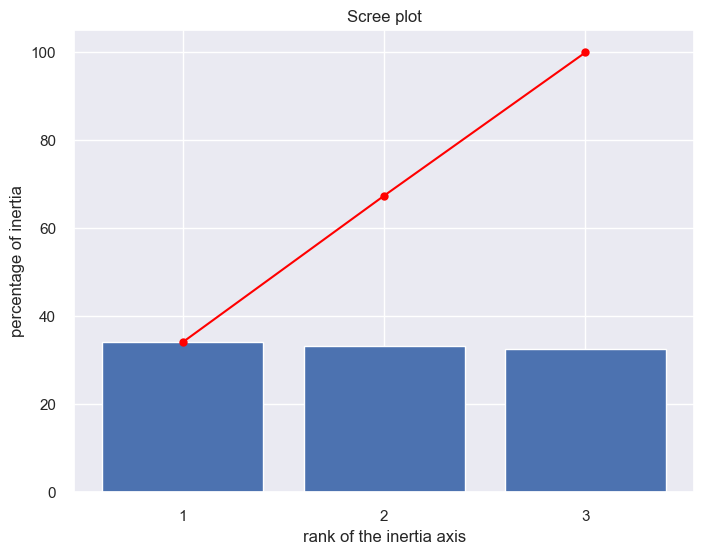

In [16]:
# PCA
n_comp = 3 # number of components
pca = decomposition.PCA(n_components=n_comp).fit(X_rfm_scaled)
X_rfm_projected = pca.transform(X_rfm_scaled)

# Scree plot
display_scree_plot(pca)

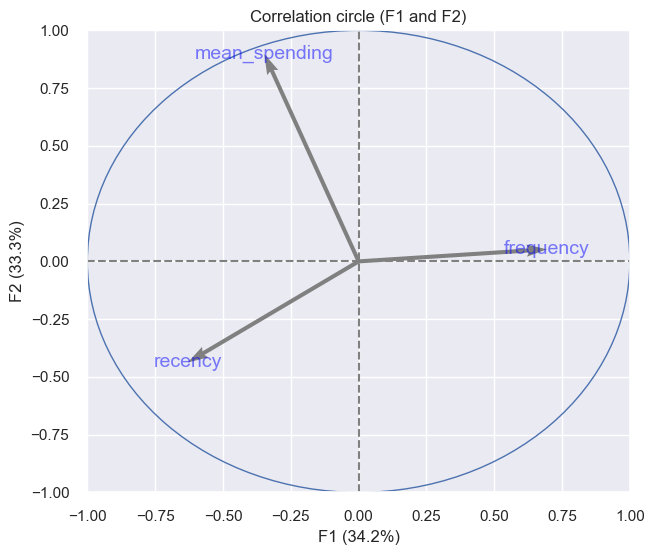

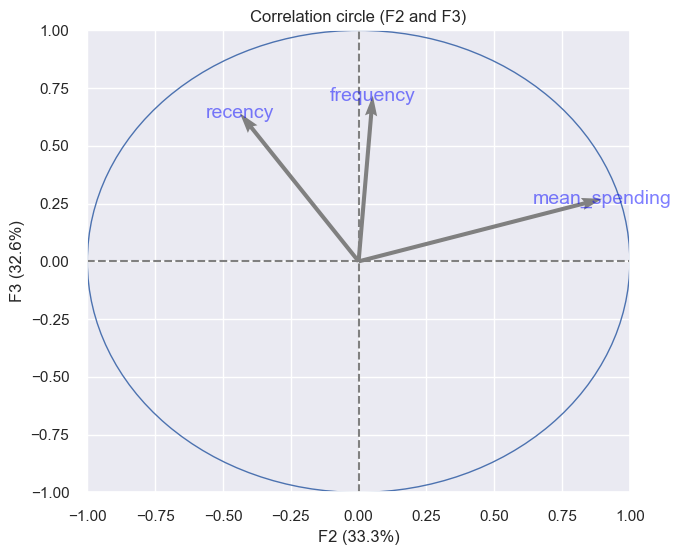

In [17]:
# Correlation circle
pcs = pca.components_
axis_ranks = [(0,1), (1,2)]
labels = X_rfm.columns
display_circles(pcs, n_comp, pca, axis_ranks, labels=labels)

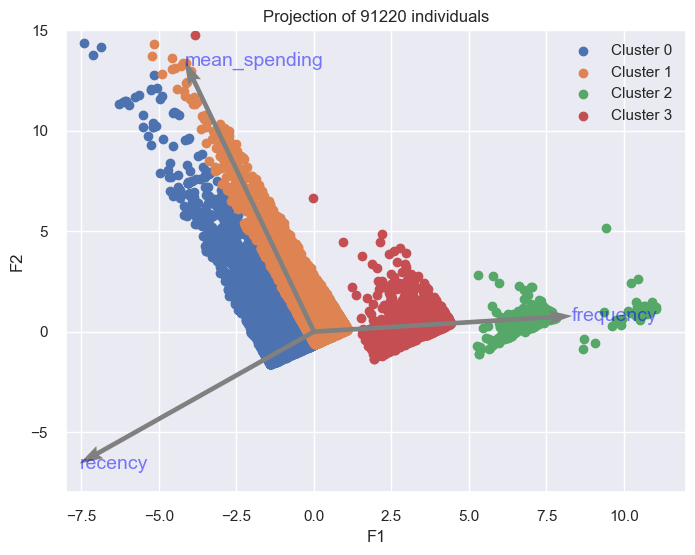

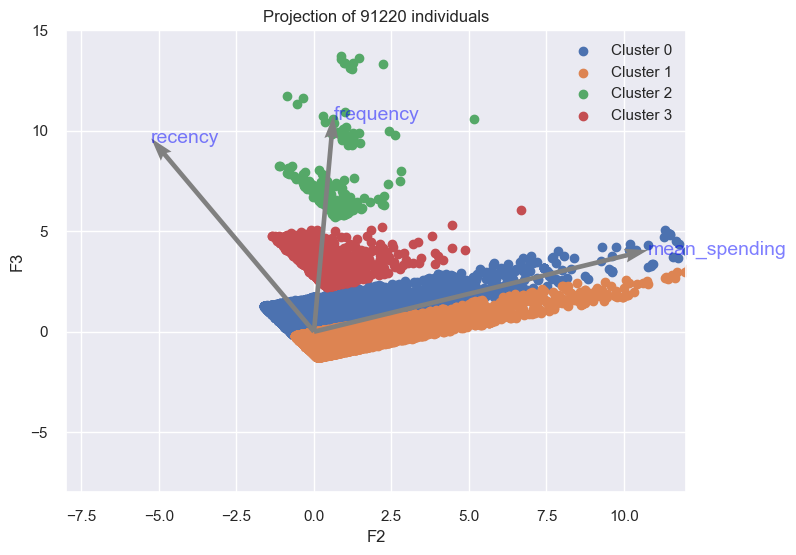

In [18]:
display_pca(X_rfm_projected, pcs, axis_ranks, clusters, labels, show_features=True, xmin=-8, xmax=12, ymin=-8, ymax=15)

3D visualization

In [19]:
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(projection='3d')
# x = X_rfm_projected[:, 0]
# y = X_rfm_projected[:, 1]
# z = X_rfm_projected[:, 2]
# ax.scatter(x, y, z, c=clusters, cmap='viridis')
# ax.set_xlabel('F1')
# ax.set_ylabel('F2')
# ax.set_zlabel('F3');

#### Visualization in features space

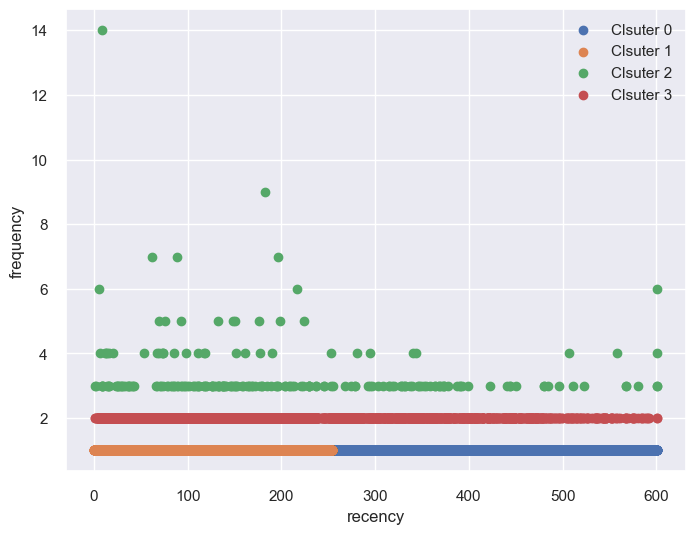

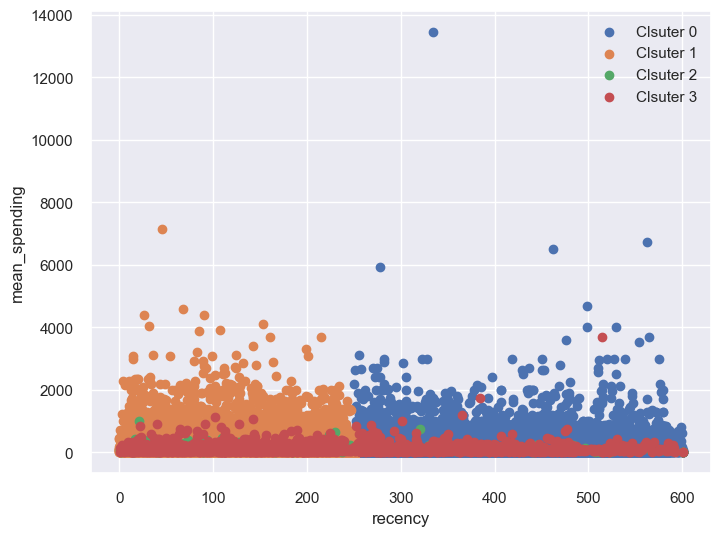

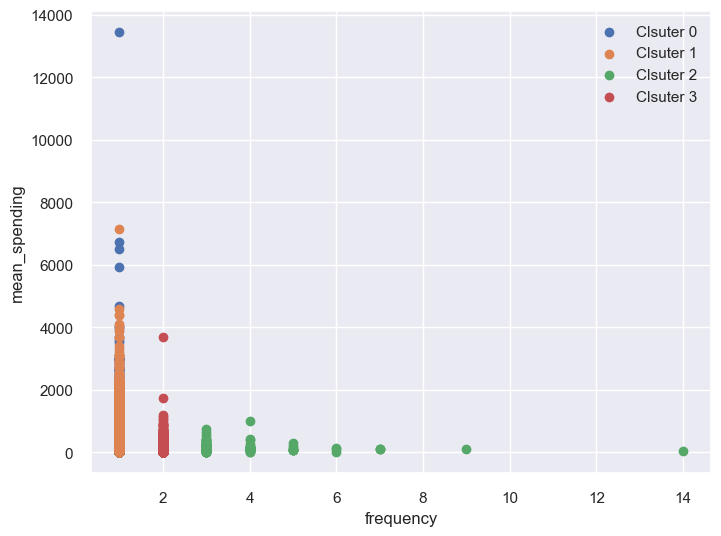

In [20]:
for (i, j) in ((0,1), (0,2), (1,2)):
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfm.iloc[mask, i], X_rfm.iloc[mask, j], label='Clsuter {}'.format(cluster))
    plt.xlabel(X_rfm.columns[i])
    plt.ylabel(X_rfm.columns[j])
    plt.legend();

#### Box plots

In [21]:
df_rfm['cluster'] = clusters

Let's draw the boxplots referenced by features and grouped by clusters

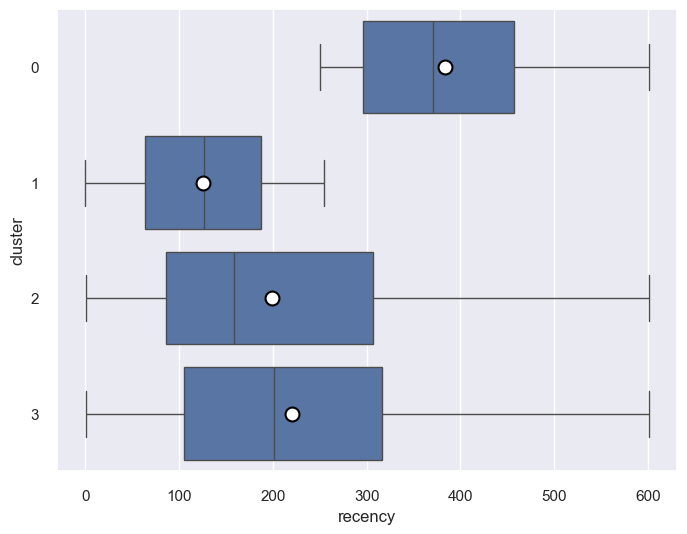

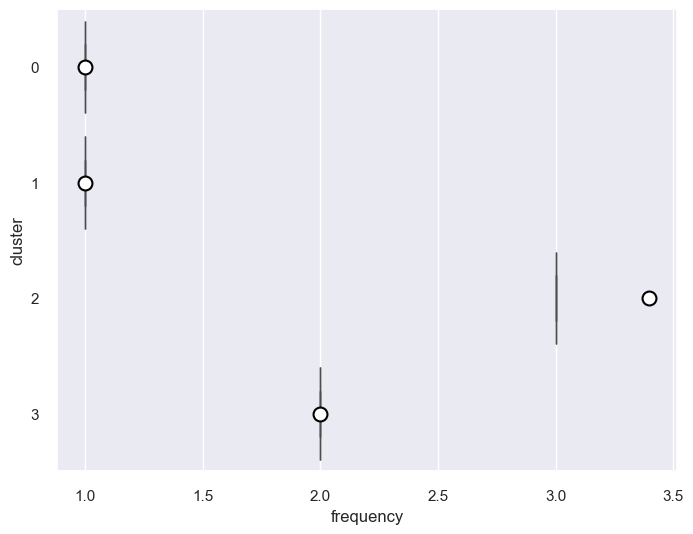

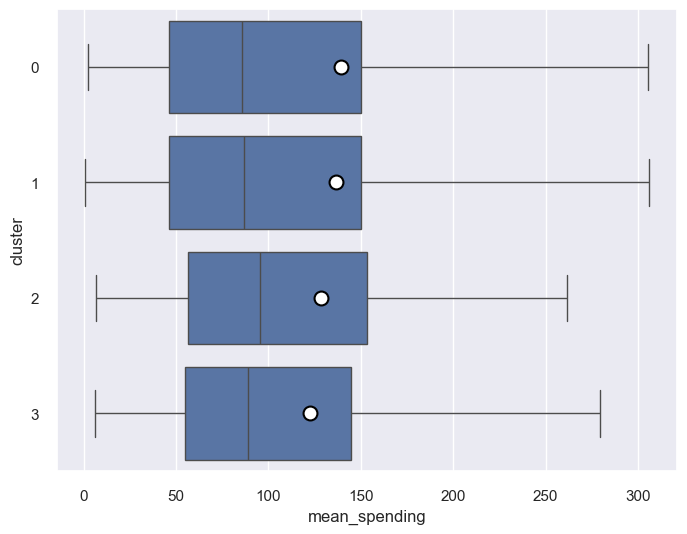

In [22]:
for col in df_rfm.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=df_rfm, orient='h', showfliers=False, showmeans=True,
               meanprops=meanprops)

#### Distribution plots

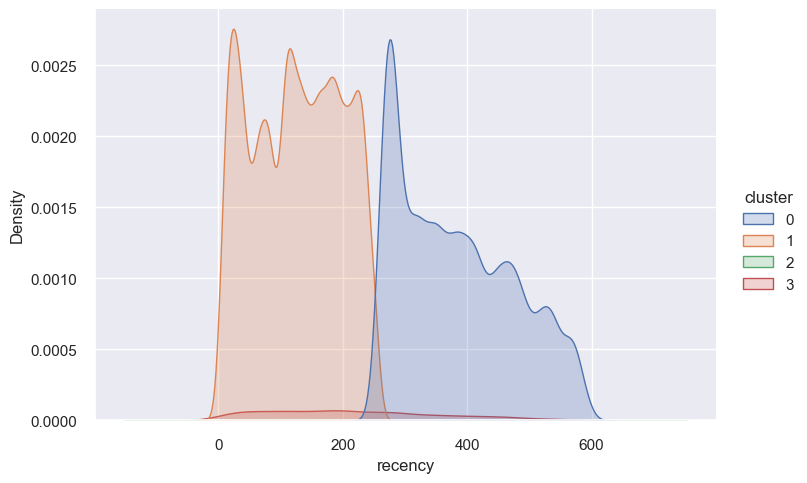

In [23]:
sns.displot(x='recency', data=df_rfm, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5);

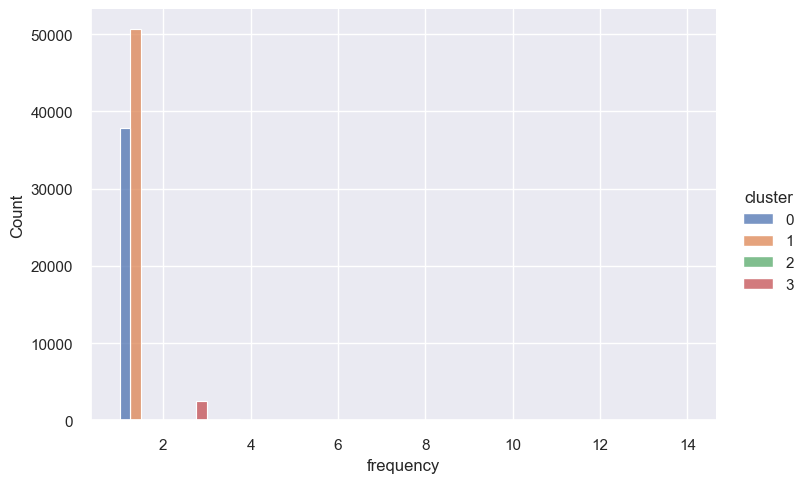

In [24]:
sns.displot(x='frequency', data=df_rfm, hue='cluster', kind='hist', palette='deep', aspect=1.5, 
            binwidth=1, multiple='dodge');

In [25]:
pd.crosstab(df_rfm['frequency'], df_rfm['cluster'])

cluster,0,1,2,3
frequency,,,,
1,37808,50719,0,0
2,0,0,0,2479
3,0,0,168,0
4,0,0,29,0
5,0,0,9,0
6,0,0,3,0
7,0,0,3,0
9,0,0,1,0
14,0,0,1,0


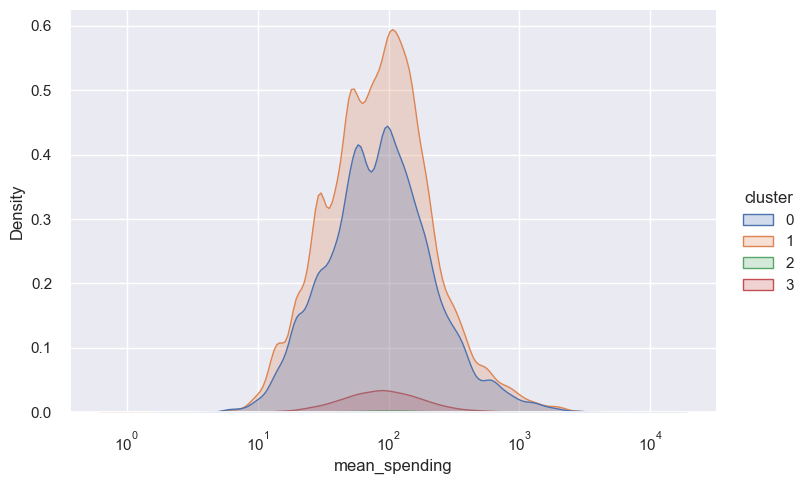

In [26]:
sns.displot(x='mean_spending', data=df_rfm, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5,
           log_scale=True);

We can conclude that:
- Cluster 0 represents recent customers (< 250 days)
- Cluster 1 represents long-standing customers (> 250 days)
- Cluster 2 represents customers who have placed multiple orders
- Cluster 3 represents customers who spend a lot (around 1,000 on average)

## DBSCAN

In [27]:
from sklearn.cluster import DBSCAN

In [28]:
X_rfm_sample = X_rfm.sample(20000, random_state=1)
scaler = StandardScaler()
X_rfm_scaled_sample = scaler.fit_transform(X_rfm_sample)
X_rfm_scaled_sample = pd.DataFrame(X_rfm_scaled_sample, 
                                   index=X_rfm_sample.index, columns=X_rfm_sample.columns)

In [29]:
db = DBSCAN(eps=1, min_samples=5)
db.fit(X_rfm_scaled_sample)
pd.Series(db.labels_).value_counts()

 0    19409
 1      524
 2       39
-1       20
 3        8
Name: count, dtype: int64

After several attempts with different values ​​for the `eps` and `min_sample` parameters, I did not get satisfactory results. Either most of the clusters are too sparsely populated, or there is too much noise (value -1).

## Hierarchical Clustering

In [30]:
from sklearn.cluster import AgglomerativeClustering

Since hierarchical clustering is slow, we will perform the clustering on a sample of the data

In [31]:
X_rfm_sample = X_rfm.sample(10000, random_state=1)
X_rfm_scaled_sample = scaler.transform(X_rfm_sample)
X_rfm_scaled_sample = pd.DataFrame(X_rfm_scaled_sample, 
                                   index=X_rfm_sample.index, columns=X_rfm_sample.columns)

In [32]:
agglo = AgglomerativeClustering(n_clusters=n_clust, linkage='ward')
agglo.fit(X_rfm_scaled_sample)
clusters = agglo.labels_

In [33]:
# Number of clients per cluster if we had the same number of clients as in X_rfm
(pd.Series(clusters).value_counts(normalize=True) * X_rfm.shape[0]).astype('int')

0    64127
3    20643
2     3603
1     2846
Name: proportion, dtype: int64

### Visualization

#### Visalization on factorial planes

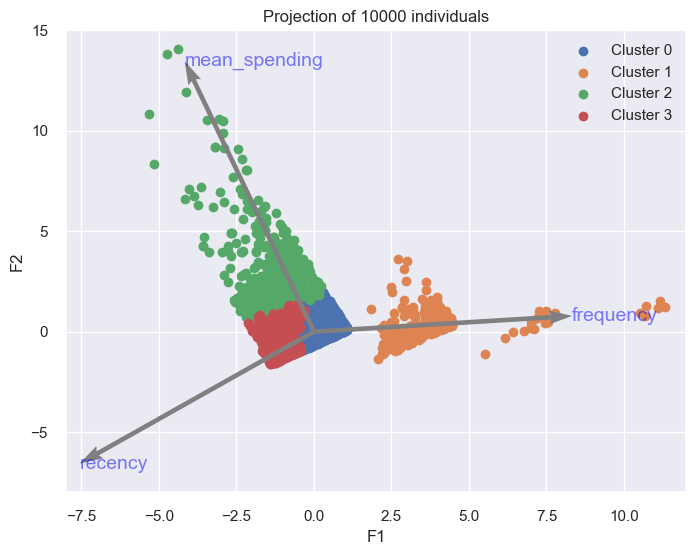

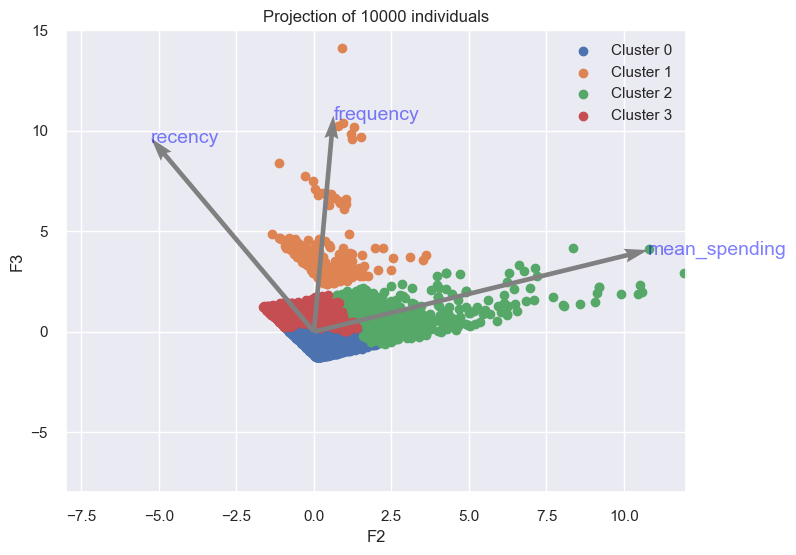

In [34]:
X_rfm_projected = pca.transform(X_rfm_scaled_sample)
display_pca(X_rfm_projected, pcs, axis_ranks, clusters, labels, show_features=True, xmin=-8, xmax=12, ymin=-8, ymax=15)

#### Visualization in features space

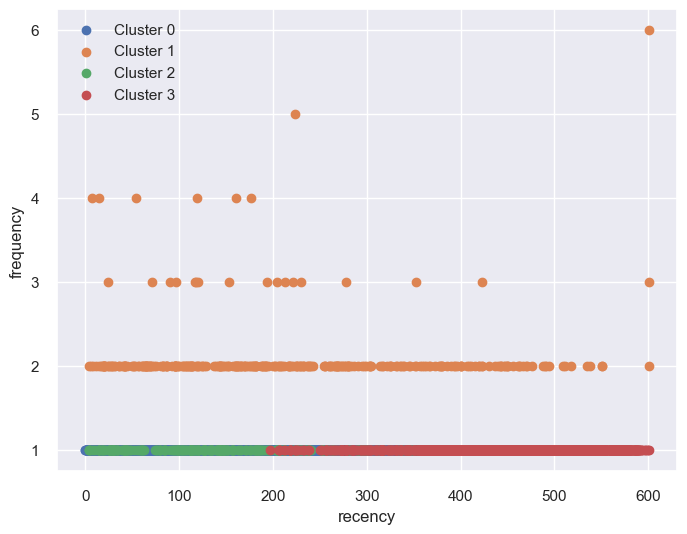

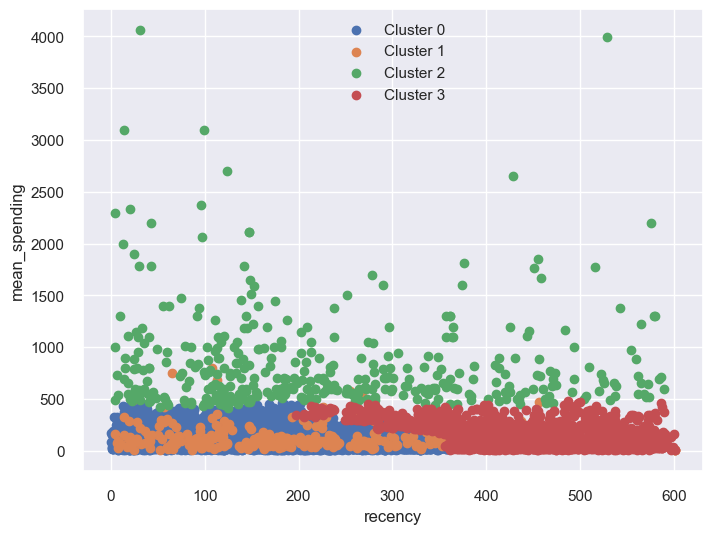

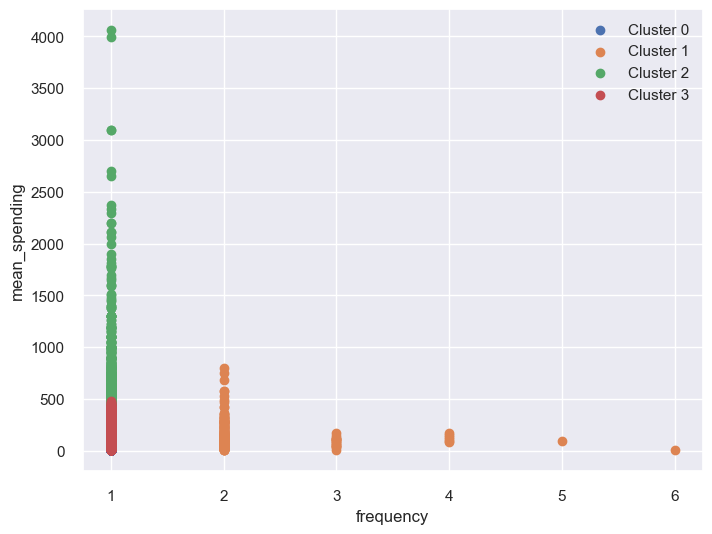

In [35]:
for (i, j) in ((0,1), (0,2), (1,2)):
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfm_sample.iloc[mask, i], X_rfm_sample.iloc[mask, j], label='Cluster {}'.format(cluster))
    #plt.xticks(rotation=30)
    plt.xlabel(X_rfm.columns[i])
    plt.ylabel(X_rfm.columns[j])
    plt.legend();

In [36]:
X_rfm_sample['cluster'] = clusters

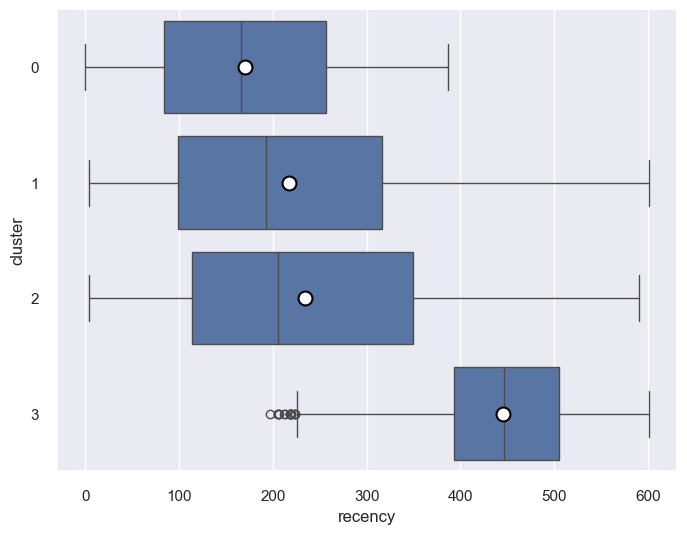

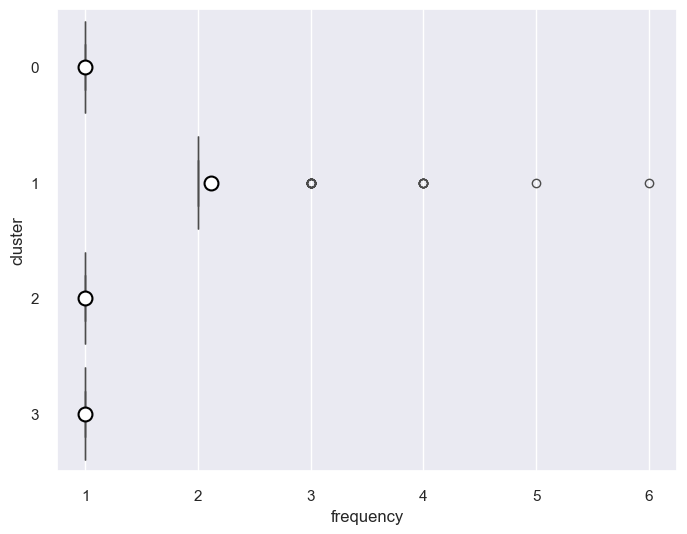

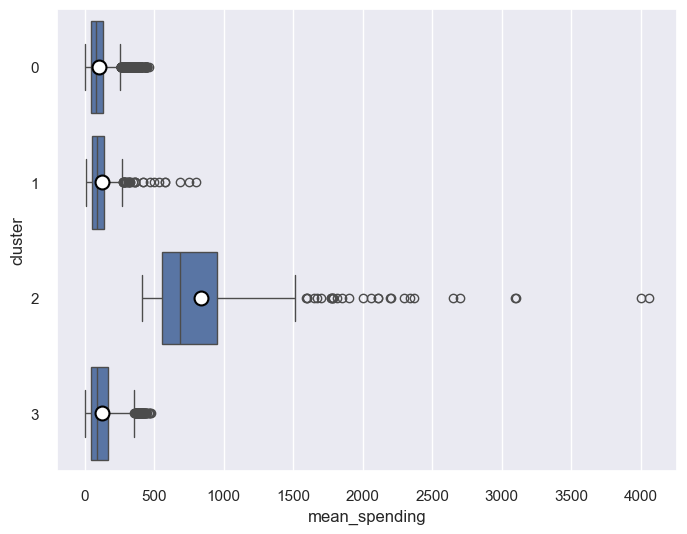

In [37]:
for col in df_rfm.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=X_rfm_sample, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

Similar results to KMeans are obtained with a cluster for recent customers, old customers, frequent customers and high spenders.

## Comparison

In [38]:
from time import time

In [39]:
print(42 * "_")
print("model\t\ttime\tsilhouette")

#KMeans
t0 = time()
kmeans.fit(X_rfm_scaled_sample)
fit_time = time() - t0
results = ['kmeans', fit_time, silhouette_score(X_rfm_scaled_sample, kmeans.labels_, metric='euclidean')]
formatter_result = (
    "{:9s}\t{:.3f}s\t{:.3f}"
)
print(formatter_result.format(*results))

#AgglomerativeClustering
t0 = time()
agglo.fit(X_rfm_scaled_sample)
fit_time = time() - t0
results = ['agglo', fit_time, silhouette_score(X_rfm_scaled_sample, agglo.labels_, metric='euclidean')]
formatter_result = (
    "{:9s}\t{:.3f}s\t{:.3f}"
)
print(formatter_result.format(*results))

__________________________________________
model		time	silhouette


kmeans   	0.008s	0.496
agglo    	2.756s	0.473


We see that the silhouette coefficients are similar but that `KMeans` is much faster than `AggloAgglomerativeClustering`. We will therefore use `KMeans`.

## Linear dimensionality reduction

### Factor Analysis

In [40]:
from sklearn.decomposition import FactorAnalysis

In [41]:
fa = FactorAnalysis(n_components=2)
X_rfm_fa = fa.fit_transform(X_rfm_scaled)

In [42]:
kmeans.fit(X_rfm_scaled)
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3], dtype=int32)

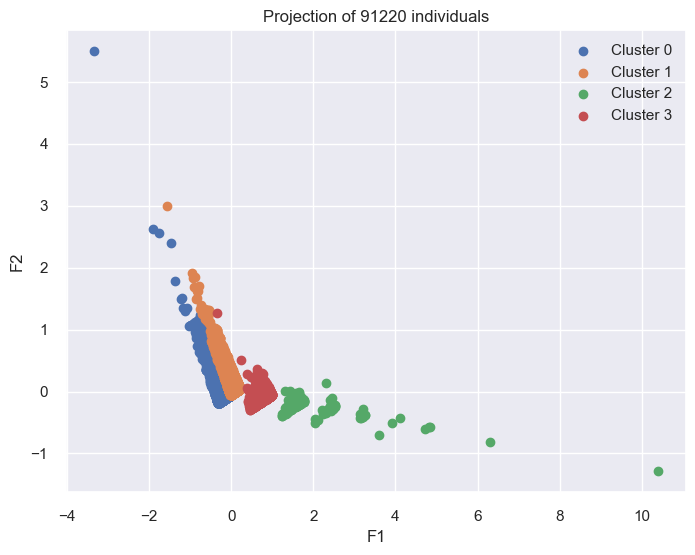

In [43]:
display_pca(X_rfm_fa, pcs, axis_ranks=[(0,1)], clusters=clusters, labels=labels, show_features=False)

Results similar to PCA.

### Non-Negative Matrix Factorization

In [44]:
from sklearn.decomposition import NMF

In [45]:
nmf = NMF(n_components=2, max_iter=400)
X_rfm_minmax = MinMaxScaler().fit_transform(X_rfm) # MinMax scaling to have positive values
X_rfm_nmf = nmf.fit_transform(X_rfm_minmax)

In [46]:
kmeans.fit(X_rfm_minmax)
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3], dtype=int32)

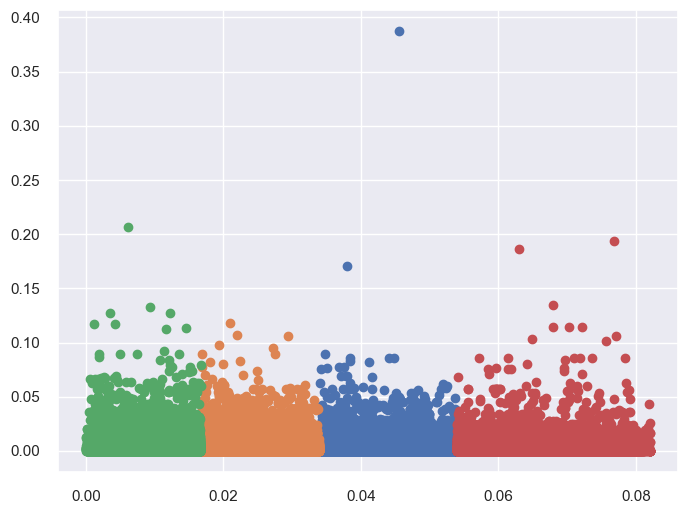

In [47]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_nmf[mask,0], X_rfm_nmf[mask,1])

The clusters are quite distinct but stuck together.

## Non-linear dimensionality reduction

### TSNE

In [48]:
from sklearn.manifold import TSNE

In [49]:
X_rfm_sample = X_rfm.sample(5000, random_state=0) # running for minutes if taking all the data
X_rfm_scaled_sample = scaler.transform(X_rfm_sample)
X_rfm_scaled_sample = pd.DataFrame(X_rfm_scaled_sample, 
                                   index=X_rfm_sample.index, columns=X_rfm_sample.columns)

In [50]:
tsne = TSNE(n_components=2, init='pca')
X_rfm_tsne = tsne.fit_transform(X_rfm_scaled_sample)

In [51]:
kmeans.fit(X_rfm_scaled_sample)
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3], dtype=int32)

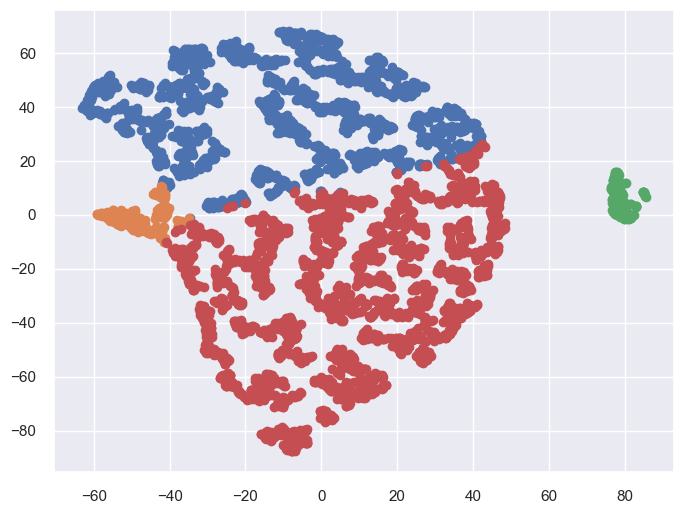

In [52]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_tsne[mask,0], X_rfm_tsne[mask,1])

### Isomap

In [53]:
from sklearn.manifold import Isomap

In [54]:
isomap = Isomap(n_components=2, n_neighbors=10)
X_rfm_isomap = isomap.fit_transform(X_rfm_scaled_sample)

/Users/gabriel/Documents/Git/Segment customers of an e-commerce/.venv/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/gabriel/Documents/Git/Segment customers of an e-commerce/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


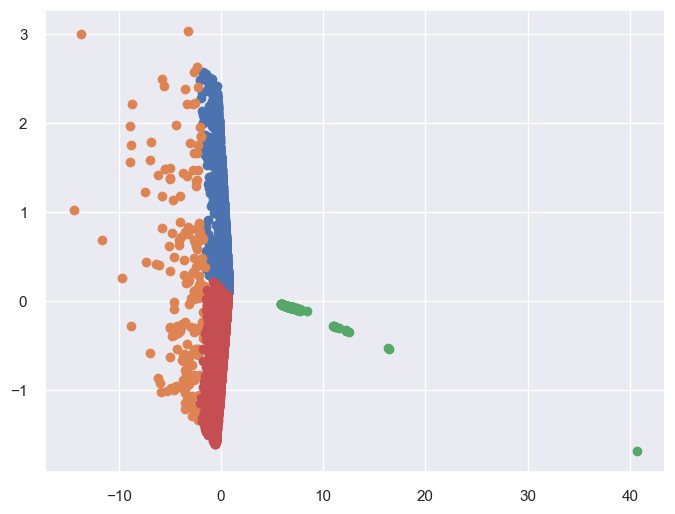

In [55]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_isomap[mask,0], X_rfm_isomap[mask,1])

### LLE

In [56]:
from sklearn.manifold import LocallyLinearEmbedding

In [57]:
lle = LocallyLinearEmbedding(n_components=2, eigen_solver='dense')
X_rfm_lle = lle.fit_transform(X_rfm_scaled_sample)

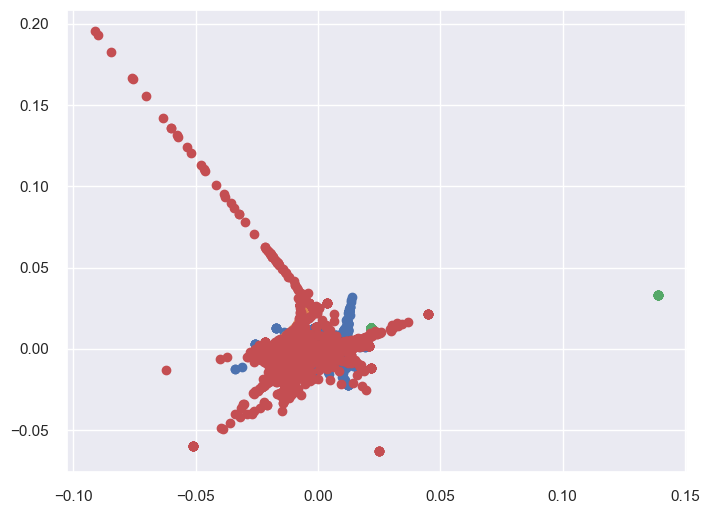

In [58]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_lle[mask,0], X_rfm_lle[mask,1])

### Spectral Embedding

In [59]:
from sklearn.manifold import SpectralEmbedding

In [60]:
spe = SpectralEmbedding(n_components=2)
X_rfm_spe = spe.fit_transform(X_rfm_scaled_sample)

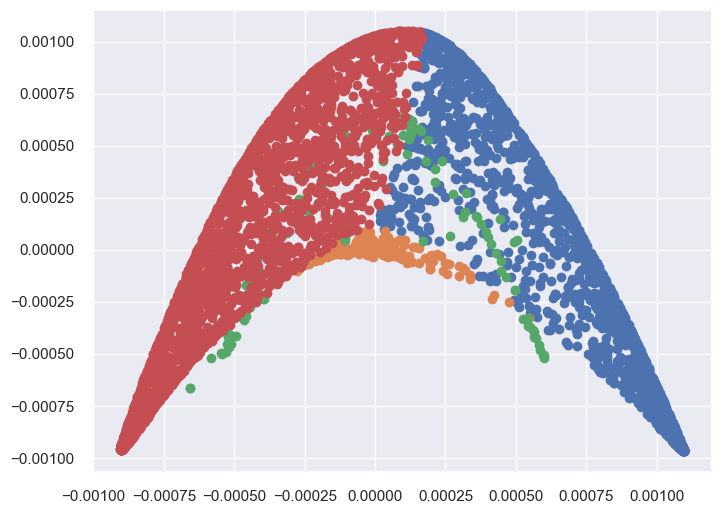

In [61]:
plt.figure()
for cluster in np.unique(clusters):
    mask = clusters == cluster
    plt.scatter(X_rfm_spe[mask,0], X_rfm_spe[mask,1])

The results are not satisfactory and computing times are very long.